In [1]:
from fastai.collab import *
from fastai.tabular import *
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

In [2]:
def get_data(path, standard_type = 'KD', transformation = None):
    df_all = pd.read_csv(path, usecols=['compound_id', 'target_id',
                                        'standard_type', 'standard_relation', 'standard_value', 'standard_units'])
    df_filtered = df_all[df_all.standard_value!=0].copy()
    df_filtered = df_filtered[(df_all.standard_type==standard_type) & 
                  (df_all.standard_relation=='=')].dropna().copy()
    df_filtered = df_filtered[~df_filtered.target_id.str.contains(',')]
    if transformation == None:
        target_name = standard_type
        df_filtered[target_nanme] = df_filtered['standard_value']
    else:
        target_name = standard_type + transformation.__name__
        df_filtered[target_name] = transformation(df_filtered['standard_value'])
    
    return df_filtered, target_name

In [235]:
def plot_preds(pred, target, target_name='target'):
    # plot a comparison between prediction and actual result
    fig, ax = plt.subplots(1, 2)
    axis_min = np.min([np.array(pred).flatten().min(), np.array(target).flatten().min()])
    axis_max = np.max([np.array(pred).flatten().max(), np.array(target).flatten().max()])
    ax[0].scatter(pred, target, alpha=0.02)
    ax[0].set_xlim([axis_min, axis_max])
    ax[0].set_xlabel(target_name + ' prediction')
    ax[0].set_ylim([axis_min, axis_max])
    ax[0].set_ylabel(target_name + ' actual')
    ax[0].set_aspect('equal')
    slope, intercept, r_value, p_value, std_err = stats.linregress(pred, target.flatten())
    ax[0].set_title("r_squared: {}".format(r_value**2) + "slope: {}".format(slope))
    ax[1].hist(pred/target, np.linspace(-2, 2, 100))
    ax[1].set_title('Histogram of prediction/target')

In [3]:
path = Path('/home/jupyter/.fastai/data/kinase/DTC_data.csv')

In [32]:
columns = df_DTC.columns; columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments'],
      dtype='object')

In [4]:
df_Kd, target_name = get_data(path, standard_type='KD', transformation=np.log)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [175]:
df_Kd.tail()

,compound_id,target_id,standard_type,standard_relation,standard_value,standard_units,KDlog
5932528,CHEMBL3545051,P36888,KD,=,74.0,NM,4.304065
5959350,CHEMBL3545051,P10721,KD,=,280.0,NM,5.634790
5971861,CHEMBL3545051,P00533,KD,=,140.0,NM,4.941642
5971862,CHEMBL3545051,P00533,KD,=,25.0,NM,3.218876
5977267,CHEMBL3545267,O35904,KD,=,6.2,NM,1.824549


In [123]:
df_Kd.shape

(32625, 7)

In [179]:
df_Kd_train = df_Kd.iloc[:26000, :].copy()
df_Kd_test = df_Kd.iloc[26001:, :].copy()

# Generate data

In [224]:
Kd_data = CollabDataBunch.from_df(df_Kd, user_name='compound_id',
                                         item_name='target_id',
                                         rating_name=target_name, 
                                         test=df_Kd_test,
                                         pct_val=0.2,
                                         seed=40)

In [209]:
Kd_data.show_batch()

compound_id,target_id,target
CHEMBL705,P48443,3.4011974334716797
CHEMBL553,Q15303,5.438079357147217
CHEMBL3651162,Q63844,-0.5447271466255188
CHEMBL318267,P11473,-2.617295742034912
CHEMBL180022,O00506,2.4849066734313965


# Model using embedding

In [261]:
Kd_learn = collab_learner(Kd_data, n_factors=80, y_range=[-20, 30])

In [262]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


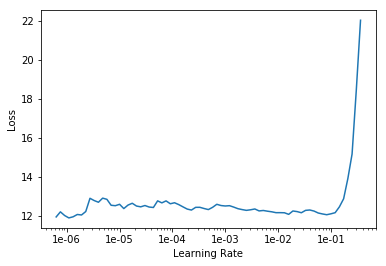

In [263]:
Kd_learn.recorder.plot()

In [264]:
Kd_learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,8.444118,7.037127
2,5.480916,6.726082
3,6.524120,8.413202
4,7.418047,8.576646
5,6.769726,7.588824
6,4.976614,6.553951
7,3.431742,5.692361
8,1.952454,5.189661
9,1.092429,5.057140
10,0.713315,5.051238


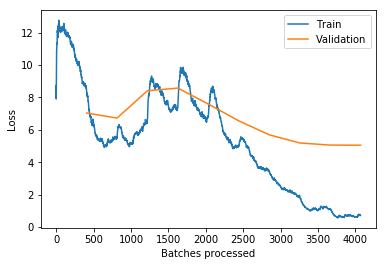

In [265]:
Kd_learn.recorder.plot_losses()

In [266]:
Kd_learn.show_results(rows=10)

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,4.628704071044922
CHEMBL1544,P10827,-2.8473122119903564,-2.2704429626464844
CHEMBL265556,P30968,0.0,0.2128925323486328
CHEMBL1721885,Q9Y4K4,5.703782558441162,5.246784210205078
CHEMBL522892,Q16513,9.200289726257324,9.470760345458984
CHEMBL3311525,O00214,12.506176948547363,13.34164810180664
CHEMBL348228,P47811,0.6418538689613342,0.8620834350585938
CHEMBL535,Q86UE8,5.799092769622803,5.248563766479492
CHEMBL522892,O14757,7.090076923370361,7.156383514404297
CHEMBL381421,P15056,4.465908050537109,5.212276458740234


In [267]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)

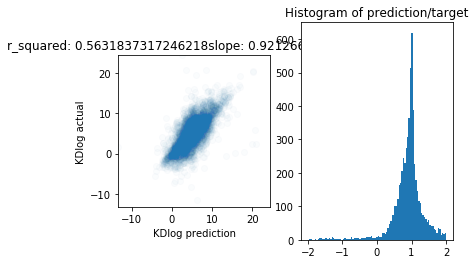

In [268]:
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

In [237]:
test_df = pd.DataFrame(list(Kd_learn.data.valid_ds.x), columns = ['name'])

In [248]:
test_df[test_df['name']=='#na#']

,name


In [251]:
temp = str(test_df.name)

In [252]:
"#na#" in temp

False

In [122]:
np.sum(df_Kd.compound_id.str.contains('#na#'))

0

In [101]:
df_Kd.reset_index().head()

,index,compound_id,target_id,standard_type,standard_relation,standard_value,standard_units,KDlog
0,216,CHEMBL135581,P00374,KD,=,0.5,NM,-0.693147
1,217,CHEMBL135581,P00374,KD,=,0.6,NM,-0.510826
2,218,CHEMBL135581,P00374,KD,=,450.0,NM,6.109248
3,219,CHEMBL135581,P00374,KD,=,1000.0,NM,6.907755
4,220,CHEMBL135581,P00374,KD,=,1200.0,NM,7.090077


In [128]:
df_Kd[(df_Kd.target_id=='P98170')&(df_Kd.KDlog>3.5)&(df_Kd.KDlog<4)]

,compound_id,target_id,standard_value,standard_units,KDlog
234223,CHEMBL184046,P98170,40.0,NM,3.688879
514972,CHEMBL360180,P98170,40.0,NM,3.688879
645175,CHEMBL310987,P98170,38.0,NM,3.637586
2305929,CHEMBL365676,P98170,50.0,NM,3.912023
2890787,CHEMBL2414998,P98170,40.0,NM,3.688879
3287092,CHEMBL183992,P98170,40.0,NM,3.688879
3460568,CHEMBL384327,P98170,38.0,NM,3.637586
3909769,CHEMBL187005,P98170,40.0,NM,3.688879
5417713,CHEMBL234346,P98170,40.0,NM,3.688879


# embedding NN (https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00)

In [269]:
Kd_NN = collab_learner(Kd_data, use_nn=True, 
                       emb_szs={'compound_id': 40, 'target_id':40}, layers=[256, 128], y_range=(-20, 30))

In [270]:
Kd_NN.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


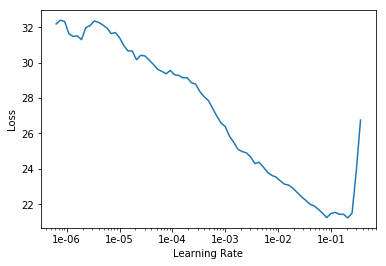

In [271]:
Kd_NN.recorder.plot()

In [272]:
Kd_NN.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,8.092835,7.002777
2,7.083485,6.826031
3,5.260640,6.407361
4,4.042236,5.750410
5,3.379128,5.433368
6,2.762931,5.120790
7,2.096077,5.052482
8,1.783967,4.964086
9,1.583162,5.192410
10,1.353708,5.019313


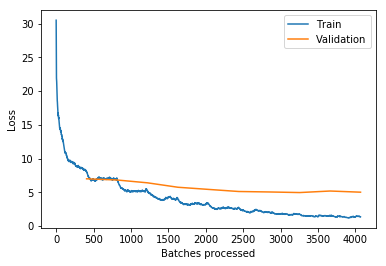

In [273]:
Kd_NN.recorder.plot_losses()

In [274]:
Kd_NN.show_results()

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,3.687488555908203
CHEMBL1544,P10827,-2.8473122119903564,-2.4090042114257812
CHEMBL265556,P30968,0.0,0.11651229858398438
CHEMBL1721885,Q9Y4K4,5.703782558441162,5.274375915527344
CHEMBL522892,Q16513,9.200289726257324,8.28076171875


In [275]:
Kd_NN_preds = Kd_NN.get_preds()

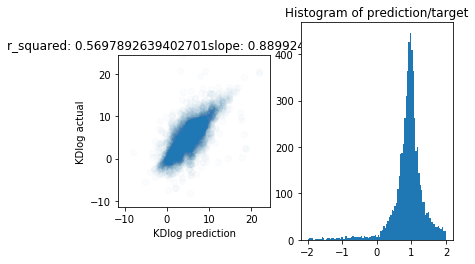

In [276]:
plot_preds(Kd_NN_preds[0].flatten(), Kd_NN_preds[1], target_name)

## TODO
1. explore the effect o embedding